# End To End Azure NLP Project: Detect AI Generated Text 
In this project, I will fine-tune a BERT model to detect AI-generated text and subsequently deploy the model on Azure. The data cleaning is performed in a separate notebook, which can be accessed through the following [link](https://github.com/joethi/Detect_AIgen_Text/blob/31ebf267850f44f6bcbcb8d4a2075858fd7c7dca/Scripts/clean_data_AIgen_hmnwrttn_text.ipynb). For the exploratory data analysis (EDA) portion of this project, please refer to the [link](https://github.com/joethi/Detect_AIgen_Text/blob/31ebf267850f44f6bcbcb8d4a2075858fd7c7dca/Scripts/EDA_bigbrain_ivypandaessays_NLP_git_v2.ipynb).

In [81]:
# pip install evaluate

In [82]:
import numpy as np
import pandas as pd
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [83]:
# # Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [84]:
print("device: ", device)

device:  cpu


## 1. Prepare the Dataset:

### 1.1. Load the Clean Datasets

In [85]:
hmn_df = pd.read_csv("../Clean_data/human_wrttn_text.csv")
ai_df = pd.read_csv("../Clean_data/ai_gen_text.csv")

In [86]:
# Concatenate the Datasets and Change the Feature Type of the Label:
from datasets import Dataset, ClassLabel, Features, Value
dataset_df = pd.concat([hmn_df, ai_df], ignore_index=True)
print("daatset_df:\n", dataset_df.head())
features_chng = Features({"Text": Value("string"),"label": ClassLabel(num_classes=2,names=[0,1])})
dataset = Dataset.from_pandas(dataset_df, features=features_chng)

daatset_df:
                                                 Text  label
0  12 Years a Slave An Analysis of the Film Essay...      0
1  20 Social Media Post Ideas to Radically Simpli...      0
2  2022 Russian Invasion of Ukraine in Global Med...      0
3  533 US 27 2001 Kyllo v United States The Use o...      0
4  A Charles Schwab Corporation Case Essay\n\nCha...      0


In [87]:
type(dataset[0]["label"])
dataset.features

{'Text': Value(dtype='string', id=None),
 'label': ClassLabel(names=[0, 1], id=None)}

In [88]:
# dataset.class_encode_column('label')
# dataset

### 1.2. Split the Datasets into Train and Test Dataset:

In [89]:
train_points = 6
val_points = int(int(train_points/0.8) * 0.2)
print("train_points: ", train_points, "\nval_points: ", val_points)
dataset_dict = dataset.train_test_split(test_size=0.2, stratify_by_column="label")
small_train_dataset = dataset_dict["train"].shuffle(seed=40).select(range(train_points))
small_test_dataset = dataset_dict["test"].shuffle(seed=40).select(range(val_points))

train_points:  6 
val_points:  1


In [90]:
small_train_dataset["Text"]

['The correct answer to the question is A tell the lawyer what he did with the money after spending it The article mentions that Hobbs received one thousand dollars from a lawyer and the lawyer informed him that he must bring a paper showing exactly what he did with the money after spending it as per his uncles will Therefore Hobbs was asked to tell the lawyer what he did with the money after spending it',
 'History of the Civil War in Sierra Leone Case Study\n\nIntroduction Brief History of the Civil War in Sierra Leone\n\nThe famous Sierra Leone Civil War erupted in March 1991 lasting for more than a decade before peaceful intervention calmed the prevailing tensions in 2002 The conflict emanated from a move by former Liberian government official Charles Taylor who returned to Liberia with the aim of upsetting the regime in the early 1990s Consequently Taylor’s actions triggered civil unrest that took root in Liberia before spreading to Sierra Leone within a short period Sierra Leone’

In [91]:
small_train_dataset["label"]

[1, 0, 1, 1, 1, 0]

In [92]:
dataset_dict

DatasetDict({
    train: Dataset({
        features: ['Text', 'label'],
        num_rows: 205268
    })
    test: Dataset({
        features: ['Text', 'label'],
        num_rows: 51318
    })
})

### 1.3. Tokenize the Datasets:

In [93]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")

/opt/anaconda3/envs/Azure_end_to_end_project/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [94]:
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True)

In [95]:
tokenized_sml_trn_ds = small_train_dataset.map(tokenize_function, batched=True)
tokenized_sml_tst_ds = small_test_dataset.map(tokenize_function, batched=True)

Map: 100%|██████████| 1/1 [00:00<00:00, 539.32 examples/s]


In [96]:
tokenizer.decode(tokenized_sml_trn_ds["input_ids"][0])

'[CLS] the correct answer to the question is a tell the lawyer what he did with the money after spending it the article mentions that hobbs received one thousand dollars from a lawyer and the lawyer informed him that he must bring a paper showing exactly what he did with the money after spending it as per his uncles will therefore hobbs was asked to tell the lawyer what he did with the money after spending it [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [97]:
# [len(tokenized_sml_trn_ds["input_ids"][i]) for i in range(1000)]

## 2. Train the Model using Native PyTorch:

### 2.1. Preprocessing Datasets for Integration with Hugging Face Models

In [98]:
# Remove the columns named "Text" since the model won't accept the text strings.
tokenized_sml_trn_ds = tokenized_sml_trn_ds.remove_columns(["Text"])
tokenized_sml_tst_ds = tokenized_sml_tst_ds.remove_columns(["Text"])

In [99]:
tokenized_sml_trn_ds
tokenized_sml_tst_ds

Dataset({
    features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1
})

In [100]:
# Rename the column name "label" to "labels" as this is expected for the model input.
tokenized_sml_trn_ds = tokenized_sml_trn_ds.rename_column("label","labels")
tokenized_sml_tst_ds = tokenized_sml_tst_ds.rename_column("label","labels")

In [101]:
tokenized_sml_trn_ds

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6
})

In [102]:
tokenized_sml_tst_ds

Dataset({
    features: ['labels', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1
})

In [103]:
# Set the Data Format to Torch:
tokenized_sml_trn_ds.set_format("torch")
tokenized_sml_tst_ds.set_format("torch")

In [104]:
tokenized_sml_trn_ds["input_ids"][0][:5]

tensor([ 101, 1996, 6149, 3437, 2000])

### 2.2. Prepare the DataLoader


In [105]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(tokenized_sml_trn_ds, shuffle=True, batch_size=8)
eval_dataloader = DataLoader(tokenized_sml_tst_ds, shuffle=True, batch_size=8)

### 2.3. Prepare the Model

In [106]:
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained("google-bert/bert-base-uncased", num_labels=2)

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

In [107]:
from torch.optim import AdamW
optimizer = AdamW(model.parameters(), lr=5e-5)

In [108]:
from transformers import get_scheduler
num_epochs = 20
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

In [109]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

### 2.4. Training Loop:

In [123]:
# pip install matplotlib

In [111]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
progress_bar = tqdm(range(num_training_steps))
model.train()
count = 0
loss_lst = []
for epoch in range(num_epochs): 
    for batch in train_dataloader:
        count += 1
        batch = {k: v.to(device) for k, v in batch.items()}

        # if epoch == 0 and count == 1:
        #     print("batch: ", batch)  
            # break
        # import pdb; pdb.set_trace() 
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        print(f"epoch: {epoch}, loss: {loss}")
        loss_lst.append(loss.item())
        progress_bar.update(1)




  5%|▌         | 1/20 [00:03<01:11,  3.76s/it]

epoch: 0, loss: 0.838150680065155


 10%|█         | 2/20 [00:07<01:04,  3.56s/it]

epoch: 1, loss: 0.6255324482917786


 15%|█▌        | 3/20 [00:10<00:59,  3.48s/it]

epoch: 2, loss: 0.5137391686439514


 20%|██        | 4/20 [00:13<00:55,  3.44s/it]

epoch: 3, loss: 0.38279780745506287


 25%|██▌       | 5/20 [00:17<00:51,  3.42s/it]

epoch: 4, loss: 0.3321742117404938


 30%|███       | 6/20 [00:20<00:47,  3.40s/it]

epoch: 5, loss: 0.26399853825569153


 35%|███▌      | 7/20 [00:24<00:44,  3.39s/it]

epoch: 6, loss: 0.2573760449886322


 40%|████      | 8/20 [00:27<00:40,  3.37s/it]

epoch: 7, loss: 0.23181475698947906


 45%|████▌     | 9/20 [00:30<00:37,  3.37s/it]

epoch: 8, loss: 0.19910061359405518


 50%|█████     | 10/20 [00:34<00:33,  3.38s/it]

epoch: 9, loss: 0.16111303865909576


 55%|█████▌    | 11/20 [00:37<00:30,  3.38s/it]

epoch: 10, loss: 0.1559191197156906


 60%|██████    | 12/20 [00:40<00:27,  3.38s/it]

epoch: 11, loss: 0.1348467618227005


 65%|██████▌   | 13/20 [00:44<00:24,  3.44s/it]

epoch: 12, loss: 0.1315905600786209


 70%|███████   | 14/20 [00:47<00:20,  3.46s/it]

epoch: 13, loss: 0.12582151591777802


 75%|███████▌  | 15/20 [00:51<00:17,  3.46s/it]

epoch: 14, loss: 0.10944955796003342


 80%|████████  | 16/20 [00:54<00:13,  3.45s/it]

epoch: 15, loss: 0.11045210808515549


 85%|████████▌ | 17/20 [00:58<00:10,  3.44s/it]

epoch: 16, loss: 0.09918961673974991


 90%|█████████ | 18/20 [01:01<00:06,  3.42s/it]

epoch: 17, loss: 0.08984313160181046


 95%|█████████▌| 19/20 [01:05<00:03,  3.41s/it]

epoch: 18, loss: 0.09363368153572083


100%|██████████| 20/20 [01:08<00:00,  3.41s/it]

epoch: 19, loss: 0.09687241911888123


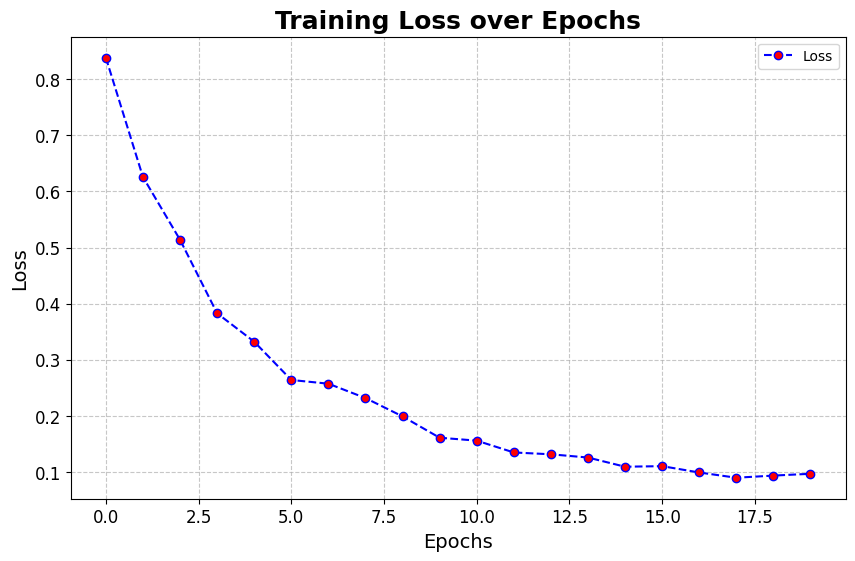

In [120]:
# Plotting
plt.figure(figsize=(10, 6))  # Increase the size of the plot
plt.plot(np.array(loss_lst), color='blue', linestyle='--', marker='o', markersize=6, markerfacecolor='red', label='Loss')

# Adding title and labels
plt.title('Training Loss over Epochs', fontsize=18, fontweight='bold')
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)

# Adding a grid
plt.grid(True, linestyle='--', alpha=0.7)

# Adding a legend
plt.legend()

# Customizing tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [113]:
batch['token_type_ids'].size()

torch.Size([6, 512])

In [114]:
for key in batch.keys():
    print("key:", key) 

key: labels
key: input_ids
key: token_type_ids
key: attention_mask


### 2.5. Evaluation Phase:

In [115]:
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in eval_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

{'accuracy': 1.0}

In [116]:
logits

tensor([[-0.8683,  0.9719]])

In [117]:
torch.argmax(logits, dim=-1)

tensor([1])

In [118]:
a = torch.randn(4, 5)
print("a: ", a)
torch.argmax(a, dim=-1)

a:  tensor([[-0.5719, -0.7091,  1.8932,  1.4689, -0.4575],
        [ 0.5674, -1.1667, -1.9380,  0.5509,  0.7978],
        [-0.6589,  0.4792,  1.0191,  0.1713,  0.3747],
        [ 0.8622,  0.9321, -1.0182, -0.5714, -1.4404]])


tensor([2, 4, 2, 1])

### 2.6. Code Sanity Check:

In [122]:
# Overfitting a few data points.
import evaluate

metric = evaluate.load("accuracy")
model.eval()
for batch in train_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    print("Targets: ", batch["labels"])
    with torch.no_grad():
        outputs = model(**batch)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)
    print("Predictions: ", predictions)
    metric.add_batch(predictions=predictions, references=batch["labels"])

metric.compute()

Targets:  tensor([1, 0, 1, 1, 0, 1])
Predictions:  tensor([1, 0, 1, 1, 0, 1])


{'accuracy': 1.0}